<a href="https://colab.research.google.com/github/labviros/computer-vision-topics/blob/master/lesson07-pose_estimation_after_calibration/pose_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pose Estimation after Camera Calibration

Because the camera is calibrated the intrinsic parameters, as well as the radial distortion coeficients, are known. Also because we know the size of the squares of the chessboard, the pose of the pattern in each image can be estimated.

[[838.48913574   0.         281.92366101]
 [  0.         833.33972168 271.82643377]
 [  0.           0.           1.        ]]
[[ 0.2370196  -1.37704004 -0.00307953 -0.01165392  2.38874093]]
[[100.   0.   0.]
 [  0. 100.   0.]
 [  0.   0. 100.]]


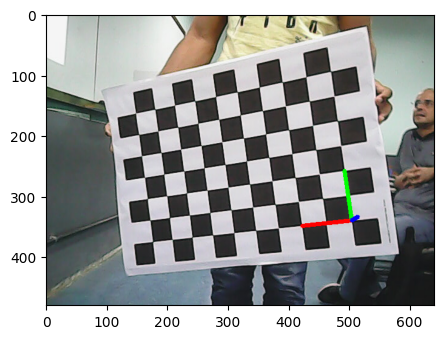

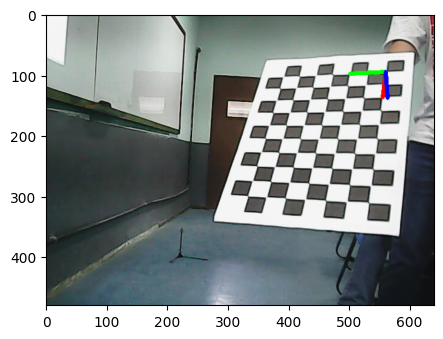

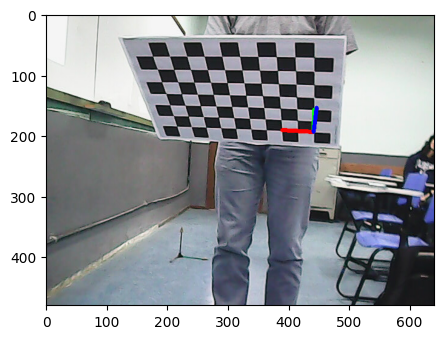

In [2]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt


def draw(img, corners, imgpts):
    corner = tuple(corners[0].astype(int).ravel())
    img = cv2.line(img, corner, tuple(imgpts[0].astype(int).ravel()), (255,0,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[1].astype(int).ravel()), (0,255,0), 5)
    img = cv2.line(img, corner, tuple(imgpts[2].astype(int).ravel()), (0,0,255), 5)

    return img

# Load previously saved data
with np.load('CalibrationResults.npz') as X:
    mtx, dist, _, _ = [X[i] for i in ('Kmtx','dist','rvecs','tvecs')]


print(mtx)
print(dist)



criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Chessboard parameters
square_size = 50
# l - lines, c - columns
l=7
c=10

# prepare 3D object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((l*c,3), np.float32)
objp[:,:2] = np.mgrid[0:c*square_size:square_size,0:l*square_size:square_size].T.reshape(-1,2)

# Axis size that will be plotted on the image
axis = np.float32([[100,0,0], [0,100,0], [0,0,100]]).reshape(-1,3)
print(axis)

images = glob.glob('./*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (c,l),None)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    if ret == True:
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)

        # Find the rotation and translation vectors.
        _,rvecs, tvecs, inliers = cv2.solvePnPRansac(objp, corners2, mtx, dist)

        # project 3D points to image plane
        imgpts, jac = cv2.projectPoints(axis, rvecs, tvecs, mtx, dist)

        img = draw(img,corners2,imgpts)
        # When using Colab, we can not use cv2.imshow. So we are showing images
        # with matplotlib.pyplot
        fig = plt.figure(figsize=(5,5))
        plt.imshow(img)

        #cv2.imshow('img',img)
        #k = cv2.waitKey(0) & 0xff
        #if k == 's':
        #    cv2.imwrite(fname[:6]+'.png', img)

#cv2.destroyAllWindows()
